### Fig. 9

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import sys, os
sys.path.append('/home/caoyuyao/dataset_14T/UID-Moji/src') 
from sklearn.neighbors import KDTree, BallTree
from visualization import ObservationMap
from utils import get_hour_list, load_weather_data, TcTools, get_elevation_grid
from quality_control import QualityControlTool
from tqdm import tqdm
from datetime import datetime, timedelta
from functools import lru_cache
import pandas as pd
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from matplotlib import font_manager 
font_path = "/mnt/cyy14/data_qg/old_draw/font"
font_files = font_manager.findSystemFonts(fontpaths=font_path)
for file in font_files:
    font_manager.fontManager.addfont(file)
plt.rcParams["font.sans-serif"] = "Arial"



plt.rcParams['axes.unicode_minus']=False 

lon_range = [117.2, 123.2]
lat_range = [27.3, 33.3]
grid_resol = 0.01

lon_tick=list(range(118,124,1))
lat_tick=list(range(28,34,1))
jwwidth=0.2

lons = np.linspace(lon_range[0], lon_range[1], int((lon_range[1] - lon_range[0])*100) + 1)
lats = np.linspace(lat_range[0], lat_range[1], int((lat_range[1] - lat_range[0])*100) + 1)
lons = np.arange((lons[0] + lons[1])/2, lon_range[1], 0.01)
lats = np.arange((lats[0] + lats[1])/2, lat_range[1], 0.01)

lon_grid, lat_grid = np.meshgrid(lons, lats)
lon_array = lon_grid.flatten().reshape(-1, 1)
lat_array = lat_grid.flatten().reshape(-1, 1)
grid_loc_array = np.hstack((lon_array, lat_array))

nf = nc.Dataset(r'./data/wind.nc','r')
wind_lats = nf.variables['latitude'][:].data
wind_lons = nf.variables['longitude'][:].data
uwind = nf.variables['u']
vwind = nf.variables['v']
wind_shape=uwind.shape


test_stations = np.load('/mnt/cyy14/data_ANON_UID_compare/stations_for_test\
/2019030100-2019093023_117.2-123.2_27.3-33.3_test_stations.npy')


import netCDF4 as nc
from utils import get_hour_list, truncate_colormap, TcTools

def load_hourly_smartphone_data(hour_name):

    data_dir = '/mnt/cyy14/\
2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_low_elev_all_users_split_hourly_data/'
    data = np.load(data_dir+hour_name+'_QCed_smartphone_data.npy')
    return data

    
lon_tick=list(range(118,124,1))
lat_tick=list(range(28,34,1))
jwwidth=0.2

def plot_radar(lst_hour_name, figure_type = 'contourf', obs_map = None, cmap = None, zorder = 4, alpha = 0.4, lel=35, width=1, linestyles='--'):
    utc_hour = (datetime.strptime(lst_hour_name, '%Y%m%d%H') - timedelta(hours = 8)).strftime('%Y%m%d%H')
    radar_dir = '/mnt/cyy2/CMA_RADA/'
    file_name = 'Z_RADR_I_CHINA_{:s}0000_O_DOR_MOC_CAP_FMT.nc'.format(utc_hour)
    ds = nc.Dataset(radar_dir + file_name, mode = 'r')
    variables = list(ds.variables)

    crf = ds['observation.prdt_crf_raw_log'][0, :, :]
    print('Data loaded!')
    lat_list = np.linspace(14.1, 51.8, 4188)
    lon_list = np.linspace(74.2, 134.7, 5640)

    new_crf = crf.copy()
    new_crf[new_crf<lel] = np.NaN
    lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)

    
    if obs_map is None:
        obs_map = ObservationMap(llon = 117.2, rlon = 123.2, llat = 27.3, ulat = 33.3)

        
        obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=10,\
                    label_left=1, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True, parallel_meridian_linewidth=jwwidth)


    if figure_type == 'contourf':
        if cmap is None:
            cs = obs_map.contourf(lon_grid, lat_grid, new_crf, levels = np.linspace(25, 50, 6), cmap = 'jet', zorder = zorder, alpha = alpha,\
                                 latlon=True)
        else:
            cs = obs_map.contourf(lon_grid, lat_grid, new_crf, levels = [lel, 100], cmap = cmap, zorder = zorder, alpha = alpha, latlon=True)
    else:
        if cmap is None:
            pass
        else:
            cmap = truncate_colormap('binary', 0.65, 0.7)
        cs = obs_map.contour(lon_grid, lat_grid, new_crf, levels = [lel], colors='green', zorder = zorder, fontsize=12, linewidths=width, latlon=True)

    return cs
    

def plot_station(hour_name, colorbar = False, ready=True):
    station_data = get_QCed_station_data(hour_name)[:, np.array([1, 2, 4])]
    print(np.nanmin(station_data[:, 2]))
    # 12
    num_colors = 10
    cmap = plt.get_cmap('Spectral_r', num_colors)
    
    obs_map = ObservationMap(llon = 117.2, rlon = 123.2, llat = 27.3, ulat = 33.3)

    
    obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=10,\
                    label_left=1, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True, parallel_meridian_linewidth=jwwidth)
    cs_pre = obs_map.scatter(station_data[:, 0], station_data[:, 1], station_data[:, 2], \
        cmap = cmap, marker_size = 1, colorbar = colorbar, zorder=4)
    plt.clim(975, 995)

    
    return station_data.shape[0], cs_pre
    




def load_station_data(hour_name = '', minute = 0):

    data_dir = '/home/caoyuyao/dataset/{:s}_AWS_pressure_60k_decoded/'.format(hour_name[:4])
    file_name = '{:s}_weather_station_data.npy'.format(hour_name)    
    return np.load(data_dir+file_name)



def get_QCed_station_data(hour_name):
    test_stations = [] 
    qc_tool = QualityControlTool()
    
    orig_station_data = load_station_data(hour_name)
    valid_ind = ~np.isnan(orig_station_data[:, 4])
    orig_station_data = orig_station_data[valid_ind, :]  
    

    station_data_dict = {}
    for i in range(len(orig_station_data)):
        station_id = str(int(orig_station_data[i, 0]))
        station_data_dict[station_id] = orig_station_data[i, 4]

    station_id_list = orig_station_data[:, 0].astype(np.int32).astype('U10')
    test_stations_ind = np.isin(station_id_list, test_stations)
    station_data = orig_station_data[~test_stations_ind, :]
    

    _, valid_ind = qc_tool.spatial_check_old(station_data[:, np.array([1, 2, 4])])
    station_data = station_data[valid_ind, :]
    

    station_lons = station_data[:, 1]
    station_lats = station_data[:, 2]
    region_ind = (station_lons>=lon_range[0] - 1) & (station_lons<=lon_range[1] + 1) & \
        (station_lats>=lat_range[0] - 1) & (station_lats<=lat_range[1] + 1)
    region_station_data = station_data[region_ind, :]

    return region_station_data


data_dir = '/mnt/cyy14/2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7\
_sea-level_low_elev_all_users_split_hourly_data/'


def draw_lk_analyses(ax, hour_name, source = 'smartphone', linewidth=1, draw_legend=True):
    lon_fname = hour_name + '_QCed_'+source+'_LK_interpolated_x'
    lat_fname = hour_name + '_QCed_'+source+'_LK_interpolated_y'
    press_fname = hour_name + '_QCed_'+source+'_LK_interpolated_z'
    
    read_folder = data_dir
    try:
        lon_df = pd.read_csv(read_folder + lon_fname, header = 0)
        lat_df = pd.read_csv(read_folder + lat_fname, header = 0)
        press_df = pd.read_csv(read_folder + press_fname, header = 0)
    except FileNotFoundError:
        exit()

    lon_list = lon_df.values
    lat_list = lat_df.values
    lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)
    press_grid = press_df.values.reshape(lat_list.shape[0], lon_list.shape[0])
    press_grid = np.transpose(press_grid)
    
    obs_map = ObservationMap(llon = lon_range[0], rlon = lon_range[1], llat = lat_range[0], ulat = lat_range[1])
    if source=='merged':
        
        obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=10,\
                    label_left=0, label_down=0, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True, parallel_meridian_linewidth=jwwidth)
    else:
        
        obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=10,\
                    label_left=0, label_down=0, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True, parallel_meridian_linewidth=jwwidth)
        
    cmap=truncate_colormap('Spectral_r', minval=0, maxval=1)
    cs = obs_map.contourf(lon_grid, lat_grid, press_grid, cmap = cmap, levels = np.linspace(976, 996, 11), \
            colorbar = False, zorder=2,alpha=1, latlon=True)
    
    plt.clim(976, 996)
    
    cmap = truncate_colormap('gist_yarg', 0, 1)
    cs_radar = plot_radar(hour_name, obs_map = obs_map, cmap = cmap, zorder = 999, alpha = 0.4, lel=30)
    
    tc_tool = TcTools()
    tc_lon, tc_lat = tc_tool.tc_center_dict[hour_name][0][:2]
    obs_map.scatter(lons = [tc_lon], lats = [tc_lat], marker = '+', marker_size = 200, color = 'red', \
        zorder = 99999)
    if draw_legend:
        u=np.squeeze(uwind[0,1,0:wind_shape[2]:2,0:wind_shape[3]:2].data) # 1:925hPa
        v=np.squeeze(vwind[0,1,0:wind_shape[2]:2,0:wind_shape[3]:2].data)
        s=u.shape
        for i in range(s[0]-2, s[0]):
            for j in range(s[0]-6, s[0]):
                u[i,j]=None
                v[i,j]=None
        obs_map.draw_ERA5_wind(lon=wind_lons[0:wind_shape[3]:2].data, lat=wind_lats[0:wind_shape[2]:2].data,\
                           u=u, v=v, latlon=True,legend_property={'size':12},\
                           legend_x=0.8, legend_y=0.05, legend_length=25, legend_label='25m/s',\
                           color='dimgrey', legend=draw_legend, headwidth=3.5)
    else:
        obs_map.draw_ERA5_wind(lon=wind_lons[0:wind_shape[3]:2].data, lat=wind_lats[0:wind_shape[2]:2].data,\
                           u=np.squeeze(uwind[0,1,0:wind_shape[2]:2,0:wind_shape[3]:2].data),\
                           v=np.squeeze(vwind[0,1,0:wind_shape[2]:2,0:wind_shape[3]:2].data), latlon=True,\
                           legend_property={'size':12}, legend_x=0.8, legend_y=0.05, legend_length=25, legend_label='25m/s',\
                           color='dimgrey', legend=draw_legend, headwidth=3.5)
    
    
    return cs, cs_radar, obs_map


def draw_difference(hour_name, ready=True, linewidth=1, radar=False):
    '''smartphone_data - station data'''
    color_name='RdYlBu_r'
    sphn_lon_fname = hour_name + '_QCed_merged_LK_interpolated_x'
    sphn_lat_fname = hour_name + '_QCed_merged_LK_interpolated_y'
    sphn_press_fname = hour_name + '_QCed_merged_LK_interpolated_z'
    station_press_fname = hour_name + '_QCed_station_LK_interpolated_z'
    try:
        sphn_lon_df = pd.read_csv(data_dir + sphn_lon_fname, header = 0)
        sphn_lat_df = pd.read_csv(data_dir + sphn_lat_fname, header = 0)
        sphn_press_df = pd.read_csv(data_dir + sphn_press_fname, header = 0)
        station_press_df = pd.read_csv(data_dir + station_press_fname, header = 0)
    except FileNotFoundError:
        exit()

    lon_list = sphn_lon_df.values
    lat_list = sphn_lat_df.values
    lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)
    sphn_press_grid = sphn_press_df.values.reshape(lat_list.shape[0], lon_list.shape[0])
    station_press_grid = station_press_df.values.reshape(lat_list.shape[0], lon_list.shape[0])
    
    sphn_press_grid = np.transpose(sphn_press_grid)
    station_press_grid = np.transpose(station_press_grid)
    
    difference_grid = sphn_press_grid - station_press_grid
    
    obs_map = ObservationMap(llon = lon_range[0], rlon = lon_range[1], llat = lat_range[0], ulat = lat_range[1])
    
    obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=10,\
                    label_left=1, label_down=1, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='lcc',\
                    lat_0=30.3, lat_1=33, lon_0=120.2, width=6.1E5, height=7E5, lock_aspect=True, parallel_meridian_linewidth=jwwidth)
    # 7, 13, (-3.5, 3.5, 8), (-3.25, 3.25, 14)
    if ready:
        cs = obs_map.contour(lon_grid, lat_grid, difference_grid, cmap = color_name, levels = np.linspace(-3, 3, 13), \
            colorbar = False, zorder=2,alpha=1, label_level=[-3, -2, -1, 1, 2, 3], linewidths=linewidth, fontsize=12, latlon=True)
    else:
        cs = obs_map.contourf(lon_grid, lat_grid, difference_grid, cmap = color_name, levels = np.linspace(-3, 3, 13), \
            colorbar = False, zorder=2,alpha=1, latlon=True)
            
    plt.clim(-3, 3)
    
    if radar:
        cs_radar = plot_radar(hour_name, obs_map = obs_map, cmap = truncate_colormap('gist_yarg', 0, 0.6), zorder = 1, alpha = 1)
    else:
        cs_radar=False
    
    cmap = truncate_colormap('gist_yarg', 0, 1)
    cs_radar = plot_radar(hour_name, obs_map = obs_map, cmap = cmap, zorder = 999, alpha = 0.4, lel=30, linestyles='--')

    cs1 = obs_map.contour(lon_grid, lat_grid, difference_grid, levels = [0], colors='black', zorder = 9999, fontsize=12, linewidths=1,\
                          linestyles='--', latlon=True)
    
    tc_tool = TcTools()
    tc_lon, tc_lat = tc_tool.tc_center_dict[hour_name][0][:2]
    print(tc_lon, tc_lat)
    obs_map.scatter(lons = [tc_lon], lats = [tc_lat], marker = '+', marker_size = 200, color = 'red', \
        zorder = 999999)
    
    return cs, cs_radar, obs_map



def draw_text(text):
    textx=0.02
    texty=0.98
    textpad='round,pad=0.2'
    
    plt.text(textx,texty, s = text, zorder=9999999, verticalalignment='top', horizontalalignment='left',\
fontsize=15, transform=ax.transAxes, bbox=dict(boxstyle=textpad, fc='white', ec='k',lw=1 ,alpha=0.7))
    
    return text

def get_tc_info(hour_name):
    tc_tool = TcTools()

    if hour_name not in tc_tool.tc_center_dict:
        return None, None, None
    
    for i in range(len(tc_tool.tc_center_dict[hour_name])):
        tmp_lon = tc_tool.tc_center_dict[hour_name][i][0]
        tmp_lat = tc_tool.tc_center_dict[hour_name][i][1]
        tmp_pressure = tc_tool.tc_center_dict[hour_name][i][2]
        if tmp_lon>125:
            continue
        return tmp_lon, tmp_lat, tmp_pressure
    return None, None, None

In [ ]:

fig_dir = '/home/qiaoge/from_cyy/picture/'
hour_list = get_hour_list('2019081002', '2019081105')[::3]
stack_data_dir = '/mnt/cyy14/2019080910-2019081110_117.2-123.2_27.3-33.3_RF_MD9999_MSL1_N30_MS0.7_sea-level_stacked_\
data_low_elev_all_users_split/'
stacked_data = np.load(stack_data_dir + '2019080910-2019081110_corrected_observer_data_len100-999999_merged.npy')

month_array = stacked_data[:, 6]
day_array = stacked_data[:, 7]
hour_array = stacked_data[:, 8]

lon_range = [117.2, 123.2]
lat_range = [27.3, 33.3]
lon_ticks = np.arange(118, 124, 2)
lat_ticks = np.arange(28, 34, 2)

time_name=['2019081014']

for i, hour_name in enumerate(['2019081014']):    
    month = int(hour_name[4:6])
    day = int(hour_name[6:8])
    hour = int(hour_name[8:10])
    time_ind = (month_array == month) & (day_array == day) & (hour_array == hour)

    hour_data = stacked_data[time_ind, :]
    hour_data[:, 3] += hour_data[:, -1]
    qc_tool = QualityControlTool()
    _, valid_ind = qc_tool.spatial_check_old(hour_data[:, np.array([1, 2, 3])])
    exec("hour_data_%1d = hour_data[valid_ind, :]"%i) 

Data loaded!
Data loaded!
Data loaded!
120.30000000000001 29.900000000000002
Data loaded!


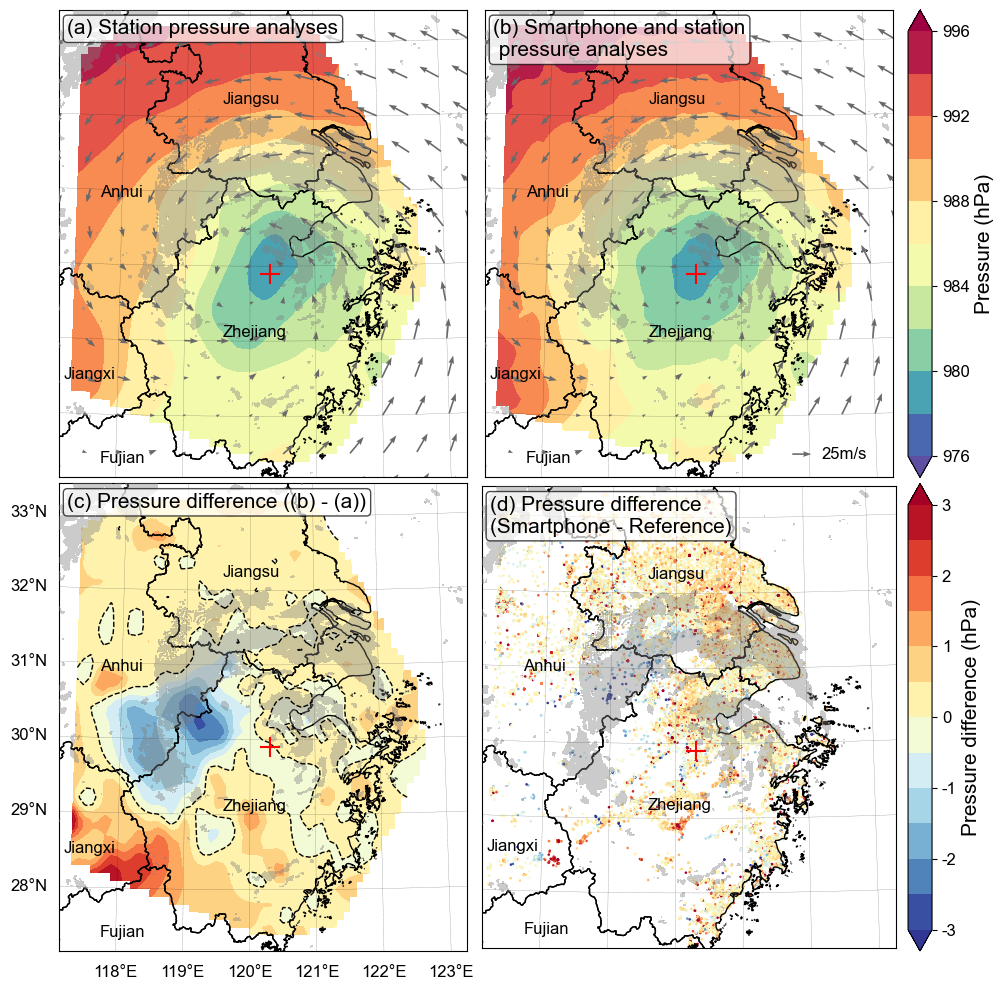

In [ ]:
fig=plt.figure(1)
fig.set_size_inches(12, 12)

mx=0.15
x0=0.345
y0=0.345/6.1*6.8+0.005
my=0.5-y0-(0.5-mx-x0)/2

'''Add terrain'''
lw=2
hour_name = '2019081014'
lon_range = [117.2, 123.2]
lat_range = [27.3, 33.3]
lon_list = np.arange(lon_range[0], lon_range[1]+0.01, 0.01)
lat_list = np.arange(lat_range[0], lat_range[1]+0.01, 0.01)
lon_grid, lat_grid = np.meshgrid(lon_list, lat_list)
_, _, elevation_grid = get_elevation_grid(lon_range, lat_range, 0.01)


textx=0.04
texty=0.91
textpad='round,pad=0.2'


# (a)
'''Add analyses'''
ax=plt.axes([mx, 1-my-y0, x0, y0])
plt.sca(ax)
cs, cs_radar, obs_map=draw_lk_analyses(ax, hour_name, 'station', linewidth=lw, draw_legend=False)
draw_text('(a) Station pressure analyses')



'''Add province name'''
tf=12
plt.text(0.4, 0.8, s = 'Jiangsu', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.4, 0.3, s = 'Zhejiang', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.6, s = 'Anhui', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.01, 0.21, s = 'Jiangxi', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.03, s = 'Fujian', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')


# (b)
ax=plt.axes([1-mx-x0, 1-my-y0, x0, y0])
plt.sca(ax)
_, _, obs_map=draw_lk_analyses(ax, hour_name, 'merged', linewidth=lw)
draw_text('(b) Smartphone and station\n pressure analyses')

'''Add province name'''
tf=12
plt.text(0.4, 0.8, s = 'Jiangsu', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.4, 0.3, s = 'Zhejiang', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.6, s = 'Anhui', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.01, 0.21, s = 'Jiangxi', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.03, s = 'Fujian', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')


# (c)
'''Add difference'''
ax=plt.axes([mx, my, x0, y0])
plt.sca(ax)
cs_d, _ , obs_map = draw_difference(hour_name=hour_name, linewidth=lw, ready=False, radar=False)
draw_text('(c) Pressure difference ((b) - (a))')

'''Add province name'''
tf=12
plt.text(0.4, 0.8, s = 'Jiangsu', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.4, 0.3, s = 'Zhejiang', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.6, s = 'Anhui', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.01, 0.21, s = 'Jiangxi', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.03, s = 'Fujian', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')


# (d)
ax=plt.axes([1-mx-x0, my, x0, y0])
plt.sca(ax)

i=0
obs_map = ObservationMap(llon = lon_range[0], rlon = lon_range[1], llat = lat_range[0], ulat = lat_range[1])  
obs_map.set_map(province = True, coastline = False, south_China_sea =False, grid=True,zorder=9999,\
                label_left=0, label_down=0, tick_label_size=12, lon_ticks=lon_tick, lat_ticks=lat_tick, projection='aea',\
                lat_0=30.35, lat_1=33, lon_0=120.2, width=6.1E5, height=6.8E5, lock_aspect=True, parallel_meridian_linewidth=jwwidth)
month = int(hour_name[4:6])
day = int(hour_name[6:8])
hour = int(hour_name[8:10])
time_ind = (month_array == month) & (day_array == day) & (hour_array == hour)
exec("hour_data=hour_data_%1d"%i)

diff = hour_data[:, 3] - hour_data[:, 5]
num_colors = 14
cmap = plt.get_cmap('RdYlBu_r', num_colors)
#cmap = plt.get_cmap('coolwarm', num_colors)  

cs1 = obs_map.scatter(hour_data[:, 1], hour_data[:, 2], diff, marker = 'o', marker_size = 0.7, cmap = cmap, colorbar = False)
plt.clim(-3.5, 3.5)
#cbar = plt.colorbar(extend = 'both', ticks = np.arange(-2, 2.4, 0.4))
#cbar.set_label('Pressure difference (hPa)', fontsize = 10)

cmap = truncate_colormap('gist_yarg', 0, 1)
cs_radar = plot_radar(hour_name, obs_map = obs_map, cmap = cmap, zorder = 999, alpha = 0.4, lel=30, linestyles='--')
tc_tool = TcTools()
tc_lon, tc_lat = tc_tool.tc_center_dict[hour_name][0][:2]
obs_map.scatter(lons = [tc_lon], lats = [tc_lat], marker = '+', marker_size = 200, color = 'red', \
    zorder = 999999)
'''Add province name'''
tf=12
plt.text(0.4, 0.8, s = 'Jiangsu', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.4, 0.3, s = 'Zhejiang', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.6, s = 'Anhui', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.01, 0.21, s = 'Jiangxi', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
plt.text(0.1, 0.03, s = 'Fujian', fontsize=tf, transform=ax.transAxes, color = 'black', zorder = 999999, fontweight = 'bold')
draw_text('(d) Pressure difference\n(Smartphone - Reference)')



fig = plt.gcf()



cbar_ax = fig.add_axes([1-mx+0.01, 1-my-y0, 0.02, y0])
cl_pre=fig.colorbar(cs, cax=cbar_ax, extend='both', orientation='vertical')
cl_pre.set_ticks(list(range(976,997,4)))
cl_pre.ax.tick_params(labelsize=12)
cbar_ax.set_ylabel('Pressure (hPa)', fontsize = 15)

cbar_ax = fig.add_axes([1-mx+0.01, my, 0.02, y0])
cl_diff=fig.colorbar(cs_d, cax=cbar_ax, extend='both', orientation='vertical')
cl_diff.set_ticks(list(range(-3,4)))
cl_diff.ax.tick_params(labelsize=12)
cbar_ax.set_ylabel('Pressure difference (hPa)', fontsize = 15)


fig_dir = '/mnt/cyy14/data_qg/old_draw/submit/'
plt.savefig(fig_dir + 'f08.png', dpi = 300, format='png', bbox_inches = 'tight')


